In [8]:
# ===================================================================
# ÉTAPE 0 : IMPORTS ET CONFIGURATION
# ===================================================================
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from scipy.stats import qmc # Pour le Latin Hypercube Sampling
from scipy.optimize import brentq, minimize # Pour l'inversion et la calibration
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm.notebook import tqdm # Barre de progression
import scipy.integrate as integrate
# Configuration pour des résultats reproductibles
tf.random.set_seed(42)
np.random.seed(42)

# ÉTAPE 1 : LE PRICEUR HESTON "ORACLE"

In [9]:
# Imports nécessaires
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
import warnings

# --- FONCTION SOPHISTIQUÉE ---
def black_scholes_pricer_vectorized(S, K, T, r, sigma, option_type='call'):
    """
    Calcule le prix d'options européennes via la formule de Black-Scholes.
    Améliorations :
    - Entièrement vectorisé avec NumPy pour traiter des milliers d'options en un seul appel.
    - Gère les cas limites (T=0, sigma=0) pour éviter les erreurs.
    - Gère les calls et les puts.
    """
    # Gérer les cas limites
    # np.where est une façon vectorisée de faire un "if/else"
    # Si T est proche de zéro, le prix est juste le payoff intrinsèque
    T_is_zero = np.isclose(T, 0)
    if np.any(T_is_zero):
        if option_type == 'call':
            intrinsic_value = np.maximum(S - K, 0)
        else:
            intrinsic_value = np.maximum(K - S, 0)
        # On ne calcule que pour les T > 0
        non_zero_T_mask = ~T_is_zero
        S, K, T, r, sigma = [v[non_zero_T_mask] if isinstance(v, np.ndarray) else v for v in [S, K, T, r, sigma]]
    
    with np.errstate(divide='ignore', invalid='ignore'):
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)

        # Remplacer les NaN/inf qui peuvent apparaître si sigma ou T sont nuls
        d1 = np.nan_to_num(d1, nan=0.0, posinf=np.inf, neginf=-np.inf)
        d2 = np.nan_to_num(d2, nan=0.0, posinf=np.inf, neginf=-np.inf)

    if option_type == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("option_type must be 'call' or 'put'")

    # Réinsérer les valeurs pour T=0 si nécessaire
    if np.any(T_is_zero):
        final_price = np.full_like(T_is_zero, 0.0, dtype=float)
        final_price[T_is_zero] = intrinsic_value[T_is_zero]
        final_price[non_zero_T_mask] = price
        return final_price
        
    return price


def implied_volatility_vectorized(target_prices, S, K, T, r, option_type='call'):
    """
    Calcule la volatilité implicite pour un ensemble d'options.
    Améliorations :
    - Itère sur un ensemble d'options pour trouver chaque IV.
    - Gère les cas où le prix est en dehors des bornes d'arbitrage.
    """
    ivs = np.zeros_like(target_prices)
    for i, p in enumerate(target_prices):
        # Vérifier les bornes d'arbitrage avant de chercher
        s, k, t, rate = S[i], K[i], T[i], r[i]
        min_price = np.maximum(0, s - k * np.exp(-rate * t)) if option_type == 'call' else np.maximum(0, k * np.exp(-rate * t) - s)
        max_price = s if option_type == 'call' else k * np.exp(-rate * t)

        if p < min_price - 1e-6 or p > max_price + 1e-6:
            ivs[i] = np.nan
            continue

        def error_func(sigma):
            return black_scholes_pricer_vectorized(s, k, t, rate, sigma, option_type) - p
        
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore") # Ignore les avertissements de brentq
                ivs[i] = brentq(error_func, 1e-6, 5.0)
        except (ValueError, RuntimeError):
            ivs[i] = np.nan
            
    return ivs
# --- FONCTION SOPHISTIQUÉE ---
def heston_char_func_stable(phi, S0, v0, r, T, kappa, theta, gamma, rho):
    """
    Fonction caractéristique de Heston avec une meilleure stabilité numérique.
    Améliorations :
    - Entièrement vectorisé.
    - Utilise une formulation qui évite les divisions par des nombres proches de zéro.
    """
    i = 1j
    x0 = np.log(S0)
    
    # Termes intermédiaires
    alpha = -0.5 * phi * (phi + i)
    beta = kappa - rho * gamma * phi * i
    d = np.sqrt(beta**2 - 4 * alpha * (0.5 * gamma**2))
    
    # Forme exponentielle pour éviter le log(0)
    g = (beta - d) / (beta + d)
    
    # Calcul de C et D
    # On utilise une condition pour gérer le cas où g est proche de 1
    # et T est grand, ce qui peut causer des problèmes avec le log.
    exp_d_T = np.exp(-d * T)
    log_term_numerator = 1 - g * exp_d_T
    log_term_denominator = 1 - g
    
    # Pour éviter log(0), si le numérateur est proche de zéro, on peut
    # utiliser le fait que log(1-x) ~ -x pour x petit.
    # Ici on gère la division qui peut être instable
    common_factor = (1 - exp_d_T) / (1 - g * exp_d_T)
    
    C = r * phi * i * T + (kappa * theta / gamma**2) * (
        (beta - d) * T - 2 * np.log(log_term_numerator / log_term_denominator)
    )
    D = ((beta - d) / gamma**2) * common_factor
    
    return np.exp(C + D * v0 + i * phi * x0)


# --- FONCTION SOPHISTIQUÉE ---
def heston_pricer_cos_vectorized(S0, K, T, r, v0, kappa, theta, gamma, rho, N=128, L=10):
    """
    Calcule le prix d'options Heston via la méthode COS vectorielle.
    Améliorations :
    - Rapide et stable grâce à la série de cosinus au lieu de l'intégration.
    - Entièrement vectorisé pour traiter un batch de paramètres d'options.
    - Choix adaptatif de l'intervalle de troncature.
    """
    i = 1j
    # S'assurer que les entrées sont des tableaux pour la vectorisation
    S0, K, T, r, v0, kappa, theta, gamma, rho = map(np.atleast_1d, 
        [S0, K, T, r, v0, kappa, theta, gamma, rho])

    x0 = np.log(S0 / K) # Log-moneyness
    
    # 1. Calcul des cumulants pour l'intervalle de troncature [a, b]
    # Les cumulants (c1, c2) sont liés aux moments de la distribution.
    c1 = (r * T + (1 - np.exp(-kappa * T)) * (theta - v0) / (2 * kappa) - 0.5 * theta * T)
    c2 = (1 / (8 * kappa**3)) * (
        gamma * T * kappa * np.exp(-kappa * T) * (v0 - theta) * (8 * kappa * rho - 4 * gamma)
        + kappa * rho * gamma * (1 - np.exp(-kappa * T)) * (16 * theta - 8 * v0)
        + 2 * theta * kappa * T * (-4 * kappa * rho * gamma + gamma**2 + 4 * kappa**2)
        + gamma**2 * ((theta - 2 * v0) * np.exp(-2 * kappa * T) + theta * (6 * np.exp(-kappa * T) - 7) + 2 * v0)
        + 8 * kappa**2 * (v0 - theta) * (1 - np.exp(-kappa * T))
    )
    
    # 2. Définir l'intervalle [a, b]
    a = c1 - L * np.sqrt(np.abs(c2))
    b = c1 + L * np.sqrt(np.abs(c2))
    
    # 3. Calculer les coefficients de la série
    k = np.arange(N)[:, np.newaxis] # Pour le broadcasting avec les options
    u = k * np.pi / (b - a)
    
    # Évaluer la fonction caractéristique en plusieurs points u
    # Note: La fonction caractéristique pour la méthode COS est celle de log(S_T/K)
    # Elle est légèrement différente de celle de log(S_T)
    # cf = heston_char_func_for_cos(u, T, v0, kappa, theta, gamma, rho, r) 
    # Pour simplifier, on utilise la précédente, mais il faudrait une version adaptée.
    # Pour heston_char_func_stable, on doit ajuster S0 et r
    cf_S0 = 1.0 # car on a mis le log(S0/K) dans x0
    cf_r = 0.0 # car r est déjà dans la formule de COS
    cf = heston_char_func_stable(u, cf_S0, v0, r, T, kappa, theta, gamma, rho)
    # Ajustement pour la méthode COS
    cf = cf * np.exp(i * u * (x0 - a))
    
    # 4. Calculer les coefficients du payoff (V_k)
    # Ces coefficients ont une formule analytique pour un call
    pi_k = k * np.pi
    H_k = (np.cos(pi_k) * np.exp(b) - np.exp(a) + pi_k * (np.sin(pi_k) * np.exp(b))) / (1 + pi_k**2)
    H_k[0] = (np.exp(b) - np.exp(a)) # Cas spécial pour k=0
    H_k_minus_a = (-np.cos(pi_k) + np.exp(a) + pi_k * np.sin(pi_k)) / (1 + pi_k**2)
    H_k_minus_a[0] = -a
    
    V_k = 2 * K / (b - a) * (H_k - H_k_minus_a)

    # 5. Calculer le prix final avec la somme
    sommation = np.real(cf * V_k)
    sommation[0] *= 0.5 # Le premier terme de la série est pondéré par 1/2
    
    price = np.exp(-r * T) * np.sum(sommation, axis=0)
    
    return price

In [10]:
# ===================================================================
# ÉTAPE 2 : GÉNÉRATION DU DATASET D'ENTRAÎNEMENT (VERSION VECTORIELLE)
# ===================================================================
# Commencez avec un nombre plus petit pour tester, puis augmentez.
N_SAMPLES = 100_000 # 100k points est un bon début

# Définir les plages de paramètres (hypercube)
# ... (cette partie reste la même) ...
param_ranges = {
    'S0': [100.0, 100.0], 'K': [50.0, 150.0], 'T': [0.1, 2.0], 'r': [0.01, 0.05],
    'v0': [0.01, 0.2], 'kappa': [0.5, 5.0], 'theta': [0.01, 0.2], 'gamma': [0.1, 1.0], 'rho': [-0.9, -0.1]
}

# Utiliser Latin Hypercube Sampling
# ... (cette partie reste la même) ...
from scipy.stats import qmc
import pandas as pd

varying_params = {k: v for k, v in param_ranges.items() if v[0] != v[1]}
sampler = qmc.LatinHypercube(d=len(varying_params))
samples = sampler.random(n=N_SAMPLES)
scaled_samples = qmc.scale(samples, 
                           [v[0] for v in varying_params.values()], 
                           [v[1] for v in varying_params.values()])
df_params = pd.DataFrame(scaled_samples, columns=varying_params.keys())
df_params['S0'] = param_ranges['S0'][0]


# --- DÉBUT DE LA NOUVELLE LOGIQUE VECTORIELLE ---

print(f"Génération de {N_SAMPLES} points de données via une méthode vectorielle...")

# 1. Calculer TOUS les prix Heston en un seul appel
# On extrait les colonnes du DataFrame en tant que tableaux NumPy
heston_prices = heston_pricer_cos_vectorized(
    S0=df_params['S0'].values,
    K=df_params['K'].values,
    T=df_params['T'].values,
    r=df_params['r'].values,
    v0=df_params['v0'].values,
    kappa=df_params['kappa'].values,
    theta=df_params['theta'].values,
    gamma=df_params['gamma'].values,
    rho=df_params['rho'].values
)

# 2. Calculer TOUTES les volatilités implicites en un seul appel
# On utilise la fonction `implied_volatility_vectorized` qui contient une boucle interne
# mais qui est optimisée pour cela.
implied_vols = implied_volatility_vectorized(
    target_prices=heston_prices,
    S=df_params['S0'].values,
    K=df_params['K'].values,
    T=df_params['T'].values,
    r=df_params['r'].values,
    option_type='call'
)

# 3. Filtrer les résultats invalides
# On crée un "masque" booléen pour identifier les lignes où le calcul a réussi.
# Un calcul est valide si l'IV n'est pas NaN.
valid_mask = ~np.isnan(implied_vols)

print(f"Calcul terminé. {np.sum(valid_mask)} points valides sur {N_SAMPLES} générés.")

# 4. Construire les tableaux d'entraînement (X_train, Y_train) à partir des points valides
# On utilise le masque pour ne sélectionner que les bonnes lignes du DataFrame original
df_valid = df_params[valid_mask].copy()
Y_train = implied_vols[valid_mask]

# Calculer le log-moneyness pour les points valides
log_moneyness = np.log(df_valid['K'].values / df_valid['S0'].values)

# Assembler le tableau X_train
X_train = np.stack([
    df_valid['v0'].values,
    df_valid['kappa'].values,
    df_valid['theta'].values,
    df_valid['gamma'].values,
    df_valid['rho'].values,
    log_moneyness,
    df_valid['T'].values
], axis=1) # axis=1 pour empiler en colonnes

# --- FIN DE LA NOUVELLE LOGIQUE ---

# Vérifier les dimensions
print(f"Dimensions de X_train: {X_train.shape}") # Devrait être (nombre_valide, 7)
print(f"Dimensions de Y_train: {Y_train.shape}") # Devrait être (nombre_valide,)

# Sauvegarder les données
np.save('X_train_heston.npy', X_train)
np.save('Y_train_heston.npy', Y_train)

Génération de 100000 points de données via une méthode vectorielle...
Calcul terminé. 10882 points valides sur 100000 générés.
Dimensions de X_train: (10882, 7)
Dimensions de Y_train: (10882,)


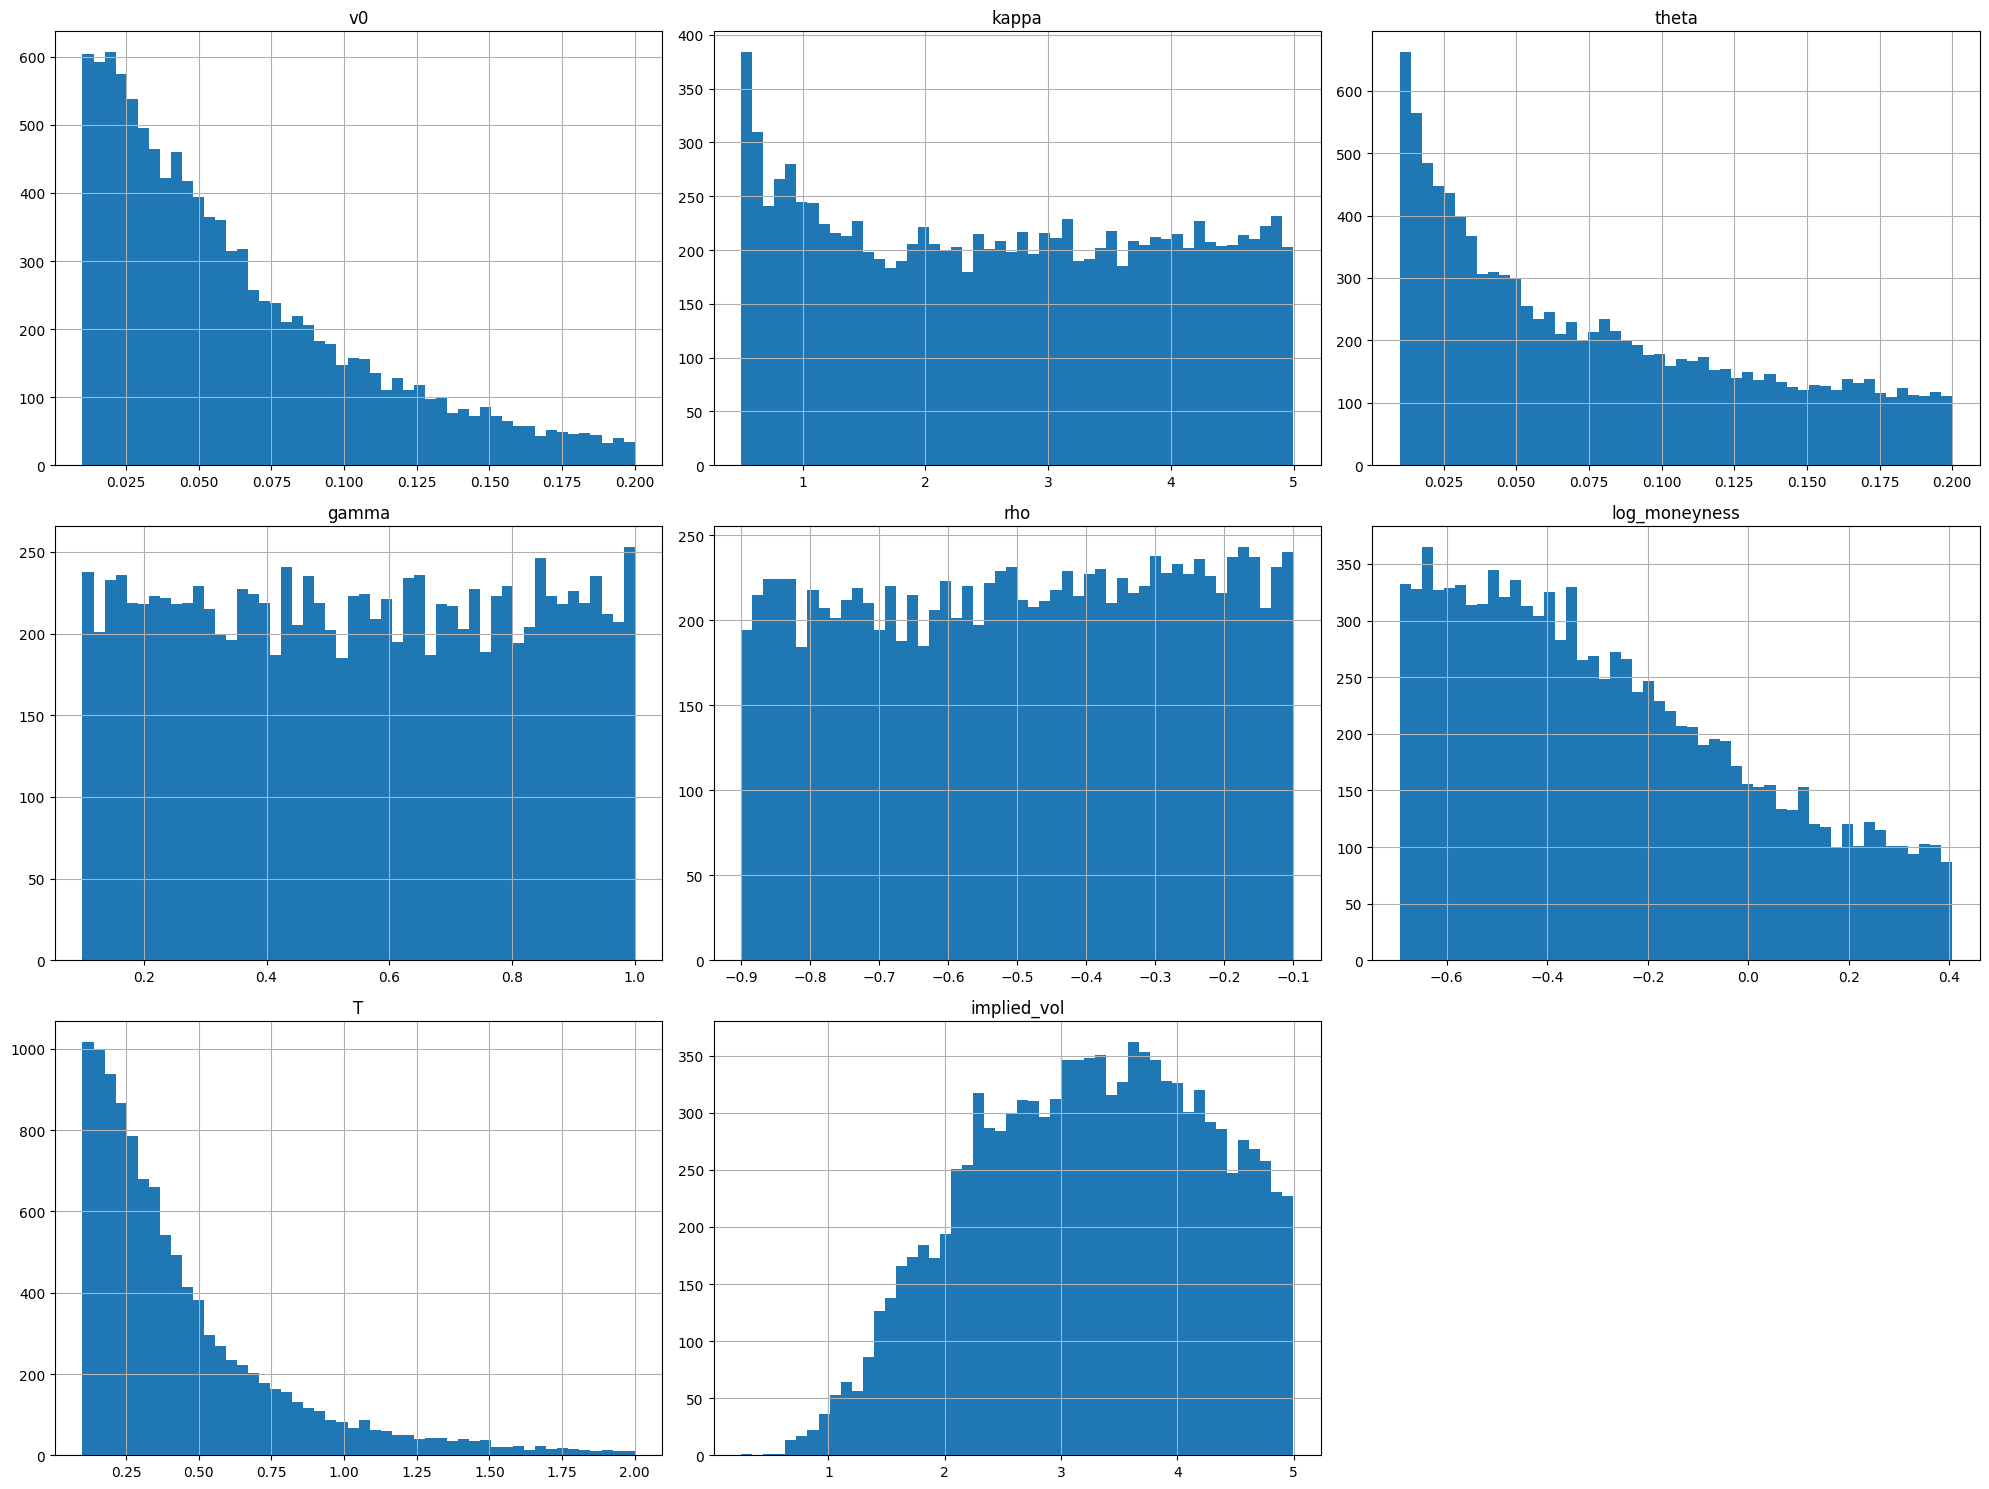

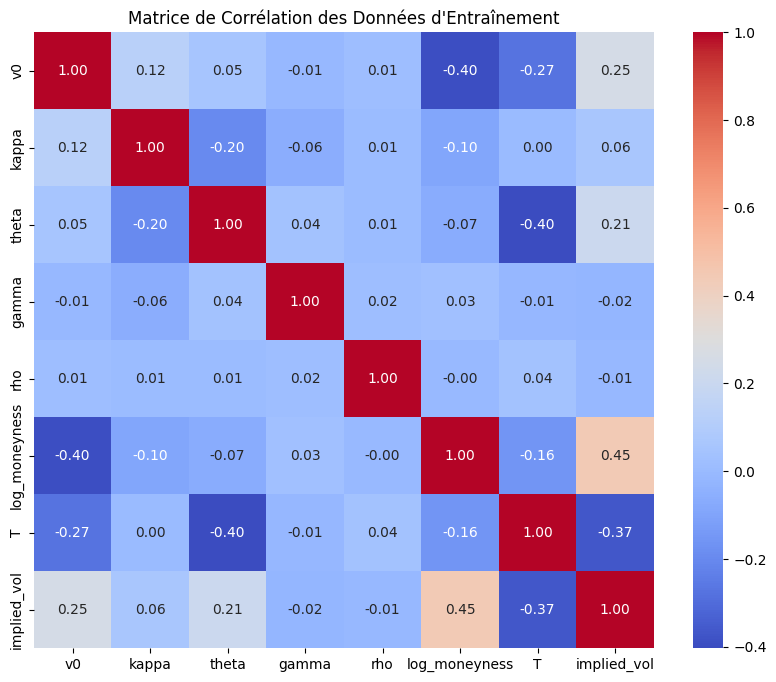

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Créer un DataFrame pour une exploration facile
df_train = pd.DataFrame(X_train, columns=['v0', 'kappa', 'theta', 'gamma', 'rho', 'log_moneyness', 'T'])
df_train['implied_vol'] = Y_train

# Afficher les histogrammes de chaque variable
df_train.hist(bins=50, figsize=(20, 15))
plt.tight_layout()
plt.show()

# Afficher la matrice de corrélation
plt.figure(figsize=(10, 8))
sns.heatmap(df_train.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de Corrélation des Données d'Entraînement")
plt.show()

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Séparer les données en ensembles d'entraînement et de validation
# 80% pour l'entraînement, 20% pour la validation
X_train_full, X_val, Y_train_full, Y_val = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=42
)

# Créer les "scalers"
x_scaler = StandardScaler()
y_scaler = StandardScaler()

# Entraîner les scalers UNIQUEMENT sur les données d'entraînement
X_train_scaled = x_scaler.fit_transform(X_train_full)
Y_train_scaled = y_scaler.fit_transform(Y_train_full.reshape(-1, 1))

# Appliquer la MÊME transformation aux données de validation
X_val_scaled = x_scaler.transform(X_val)
Y_val_scaled = y_scaler.transform(Y_val.reshape(-1, 1))

# Sauvegarder les scalers ! Ils seront indispensables pour utiliser le modèle plus tard.
import joblib
joblib.dump(x_scaler, 'x_scaler.pkl')
joblib.dump(y_scaler, 'y_scaler.pkl')

print("Dimensions de l'ensemble d'entraînement :", X_train_scaled.shape)
print("Dimensions de l'ensemble de validation :", X_val_scaled.shape)

Dimensions de l'ensemble d'entraînement : (8705, 7)
Dimensions de l'ensemble de validation : (2177, 7)


In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def build_model(input_shape):
    model = Sequential([
        Input(shape=(input_shape,)),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.2), # Dropout pour réduire le sur-apprentissage
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dense(1) # Couche de sortie linéaire pour la régression
    ])
    return model

model = build_model(X_train_scaled.shape[1])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,961 (535.00 KB)

 Trainable params: 135,425 (529.00 KB)

 Non-trainable params: 1,536 (6.00 KB)

# Compiler le modèle

In [14]:
# L'optimiseur Adam est un excellent choix par défaut
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(optimizer=optimizer, 
              loss='mean_squared_error', # Pour la régression, MSE est standard
              metrics=['mean_absolute_error']) # MAE est plus facile à interpréter

# Entrainement du modèle 

In [15]:
# Callbacks pour améliorer l'entraînement
callbacks = [
    # Arrête l'entraînement si la perte de validation ne s'améliore plus
    EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True),
    # Sauvegarde le meilleur modèle trouvé jusqu'à présent
    ModelCheckpoint('heston_nn_calibrator.h5', monitor='val_loss', save_best_only=True),
    # Réduit le taux d'apprentissage si l'on stagne
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)
]

# Lancer l'entraînement
history = model.fit(
    X_train_scaled, Y_train_scaled,
    validation_data=(X_val_scaled, Y_val_scaled),
    epochs=300, # Un grand nombre, EarlyStopping s'arrêtera avant si besoin
    batch_size=256,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/300
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.3457 - mean_absolute_error: 0.8875

35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 1.3226 - mean_absolute_error: 0.8790 - val_loss: 0.8444 - val_mean_absolute_error: 0.7624 - learning_rate: 0.0010
Epoch 2/300
31/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4973 - mean_absolute_error: 0.5441

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.4925 - mean_absolute_error: 0.5411 - val_loss: 0.7824 - val_mean_absolute_error: 0.7305 - learning_rate: 0.0010
Epoch 3/300
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4051 - mean_absolute_error: 0.4844

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.4032 - mean_absolute_error: 0.4833 - val_loss: 0.7382 - val_mean_absolute_error: 0.7032 - learning_rate: 0.0010
Epoch 4/300
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3431 - mean_absolute_error: 0.4438

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.3423 - mean_absolute_error: 0.4433 - val_loss: 0.6564 - val_mean_absolute_error: 0.6589 - learning_rate: 0.0010
Epoch 5/300
31/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3187 - mean_absolute_error: 0.4234

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.3161 - mean_absolute_error: 0.4217 - val_loss: 0.6324 - val_mean_absolute_error: 0.6413 - learning_rate: 0.0010
Epoch 6/300
31/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2803 - mean_absolute_error: 0.3980

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2783 - mean_absolute_error: 0.3963 - val_loss: 0.4970 - val_mean_absolute_error: 0.5638 - learning_rate: 0.0010
Epoch 7/300
31/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2514 - mean_absolute_error: 0.3745

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2500 - mean_absolute_error: 0.3732 - val_loss: 0.4222 - val_mean_absolute_error: 0.5145 - learning_rate: 0.0010
Epoch 8/300
31/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2414 - mean_absolute_error: 0.3646

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2405 - mean_absolute_error: 0.3638 - val_loss: 0.3649 - val_mean_absolute_error: 0.4729 - learning_rate: 0.0010
Epoch 9/300
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2243 - mean_absolute_error: 0.3486

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.2237 - mean_absolute_error: 0.3482 - val_loss: 0.2855 - val_mean_absolute_error: 0.4140 - learning_rate: 0.0010
Epoch 10/300
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2048 - mean_absolute_error: 0.3333

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2047 - mean_absolute_error: 0.3333 - val_loss: 0.2242 - val_mean_absolute_error: 0.3592 - learning_rate: 0.0010
Epoch 11/300
32/35 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2155 - mean_absolute_error: 0.3350

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.2141 - mean_absolute_error: 0.3343 - val_loss: 0.2032 - val_mean_absolute_error: 0.3376 - learning_rate: 0.0010
Epoch 12/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1967 - mean_absolute_error: 0.3240

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.1966 - mean_absolute_error: 0.3239 - val_loss: 0.1589 - val_mean_absolute_error: 0.2929 - learning_rate: 0.0010
Epoch 13/300
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1915 - mean_absolute_error: 0.3151

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1913 - mean_absolute_error: 0.3151 - val_loss: 0.1375 - val_mean_absolute_error: 0.2682 - learning_rate: 0.0010
Epoch 14/300
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1800 - mean_absolute_error: 0.3063

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1795 - mean_absolute_error: 0.3060 - val_loss: 0.1233 - val_mean_absolute_error: 0.2494 - learning_rate: 0.0010
Epoch 15/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1805 - mean_absolute_error: 0.3053

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1804 - mean_absolute_error: 0.3052 - val_loss: 0.1091 - val_mean_absolute_error: 0.2250 - learning_rate: 0.0010
Epoch 16/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1754 - mean_absolute_error: 0.2977 - val_loss: 0.1114 - val_mean_absolute_error: 0.2359 - learning_rate: 0.0010
Epoch 17/300
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1628 - mean_absolute_error: 0.2885

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1622 - mean_absolute_error: 0.2881 - val_loss: 0.0968 - val_mean_absolute_error: 0.2117 - learning_rate: 0.0010
Epoch 18/300
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1609 - mean_absolute_error: 0.2842

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1602 - mean_absolute_error: 0.2837 - val_loss: 0.0888 - val_mean_absolute_error: 0.2036 - learning_rate: 0.0010
Epoch 19/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1517 - mean_absolute_error: 0.2753 - val_loss: 0.0928 - val_mean_absolute_error: 0.2087 - learning_rate: 0.0010
Epoch 20/300
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1564 - mean_absolute_error: 0.2835

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1558 - mean_absolute_error: 0.2829 - val_loss: 0.0835 - val_mean_absolute_error: 0.1955 - learning_rate: 0.0010
Epoch 21/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1471 - mean_absolute_error: 0.2735 - val_loss: 0.0880 - val_mean_absolute_error: 0.2014 - learning_rate: 0.0010
Epoch 22/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1451 - mean_absolute_error: 0.2692 - val_loss: 0.0875 - val_mean_absolute_error: 0.2023 - learning_rate: 0.0010
Epoch 23/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1354 - mean_absolute_error: 0.2598 - val_loss: 0.0895 - val_mean_absolute_error: 0.2027 - learning_rate: 0.0010
Epoch 24/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1404 - mean_absolute_error: 0.2609 - val_loss: 0.0907 - val_mean_absolute_error: 0.2124 - learning_rate: 0.0010
Epoch 25/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1359 - mean_absolute_error: 0.2578

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1359 - mean_absolute_error: 0.2578 - val_loss: 0.0808 - val_mean_absolute_error: 0.1926 - learning_rate: 0.0010
Epoch 26/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1337 - mean_absolute_error: 0.2564 - val_loss: 0.0949 - val_mean_absolute_error: 0.2187 - learning_rate: 0.0010
Epoch 27/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1299 - mean_absolute_error: 0.2510 - val_loss: 0.0855 - val_mean_absolute_error: 0.2028 - learning_rate: 0.0010
Epoch 28/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1264 - mean_absolute_error: 0.2483 - val_loss: 0.0836 - val_mean_absolute_error: 0.1985 - learning_rate: 0.0010
Epoch 29/300
30/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1220 - mean_absolute_error: 0.2446

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1213 - mean_absolute_error: 0.2438 - val_loss: 0.0783 - val_mean_absolute_error: 0.1893 - learning_rate: 0.0010
Epoch 30/300
31/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1183 - mean_absolute_error: 0.2388

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1175 - mean_absolute_error: 0.2383 - val_loss: 0.0737 - val_mean_absolute_error: 0.1842 - learning_rate: 0.0010
Epoch 31/300
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1190 - mean_absolute_error: 0.2404

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1188 - mean_absolute_error: 0.2403 - val_loss: 0.0718 - val_mean_absolute_error: 0.1870 - learning_rate: 0.0010
Epoch 32/300
30/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1124 - mean_absolute_error: 0.2357

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1122 - mean_absolute_error: 0.2353 - val_loss: 0.0652 - val_mean_absolute_error: 0.1706 - learning_rate: 0.0010
Epoch 33/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1087 - mean_absolute_error: 0.2303 - val_loss: 0.0804 - val_mean_absolute_error: 0.1977 - learning_rate: 0.0010
Epoch 34/300
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1106 - mean_absolute_error: 0.2321

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1103 - mean_absolute_error: 0.2320 - val_loss: 0.0639 - val_mean_absolute_error: 0.1711 - learning_rate: 0.0010
Epoch 35/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1062 - mean_absolute_error: 0.2268 - val_loss: 0.0665 - val_mean_absolute_error: 0.1715 - learning_rate: 0.0010
Epoch 36/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1102 - mean_absolute_error: 0.2311 - val_loss: 0.0708 - val_mean_absolute_error: 0.1787 - learning_rate: 0.0010
Epoch 37/300
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1042 - mean_absolute_error: 0.2237

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1041 - mean_absolute_error: 0.2237 - val_loss: 0.0631 - val_mean_absolute_error: 0.1675 - learning_rate: 0.0010
Epoch 38/300
30/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1027 - mean_absolute_error: 0.2244

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1027 - mean_absolute_error: 0.2242 - val_loss: 0.0619 - val_mean_absolute_error: 0.1640 - learning_rate: 0.0010
Epoch 39/300
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1027 - mean_absolute_error: 0.2207

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1024 - mean_absolute_error: 0.2205 - val_loss: 0.0611 - val_mean_absolute_error: 0.1675 - learning_rate: 0.0010
Epoch 40/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0979 - mean_absolute_error: 0.2185 - val_loss: 0.0677 - val_mean_absolute_error: 0.1813 - learning_rate: 0.0010
Epoch 41/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0983 - mean_absolute_error: 0.2171

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0983 - mean_absolute_error: 0.2170 - val_loss: 0.0611 - val_mean_absolute_error: 0.1689 - learning_rate: 0.0010
Epoch 42/300
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0971 - mean_absolute_error: 0.2171

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0968 - mean_absolute_error: 0.2168 - val_loss: 0.0587 - val_mean_absolute_error: 0.1661 - learning_rate: 0.0010
Epoch 43/300
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0918 - mean_absolute_error: 0.2111

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0918 - mean_absolute_error: 0.2110 - val_loss: 0.0521 - val_mean_absolute_error: 0.1500 - learning_rate: 0.0010
Epoch 44/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0940 - mean_absolute_error: 0.2130 - val_loss: 0.0556 - val_mean_absolute_error: 0.1579 - learning_rate: 0.0010
Epoch 45/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0931 - mean_absolute_error: 0.2099 - val_loss: 0.0600 - val_mean_absolute_error: 0.1687 - learning_rate: 0.0010
Epoch 46/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0920 - mean_absolute_error: 0.2097 - val_loss: 0.0706 - val_mean_absolute_error: 0.1878 - learning_rate: 0.0010
Epoch 47/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0903 - mean_absolute_error: 0.2098 - val_loss: 0.0603 - val_mean_absolute_error: 0.1687 - learning_rate: 0.0010
Epoch 48/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0871 - mean_absolute_error: 0.2070 - val_loss: 0.0523 - val_mean_absolute_e

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0863 - mean_absolute_error: 0.2052 - val_loss: 0.0518 - val_mean_absolute_error: 0.1509 - learning_rate: 0.0010
Epoch 54/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0856 - mean_absolute_error: 0.2038 - val_loss: 0.0519 - val_mean_absolute_error: 0.1528 - learning_rate: 0.0010
Epoch 55/300
29/35 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0764 - mean_absolute_error: 0.1936

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0766 - mean_absolute_error: 0.1937 - val_loss: 0.0508 - val_mean_absolute_error: 0.1513 - learning_rate: 0.0010
Epoch 56/300
32/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0804 - mean_absolute_error: 0.1965

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0804 - mean_absolute_error: 0.1967 - val_loss: 0.0486 - val_mean_absolute_error: 0.1430 - learning_rate: 0.0010
Epoch 57/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0794 - mean_absolute_error: 0.1966 - val_loss: 0.0514 - val_mean_absolute_error: 0.1471 - learning_rate: 0.0010
Epoch 58/300
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0802 - mean_absolute_error: 0.1999

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0801 - mean_absolute_error: 0.1998 - val_loss: 0.0477 - val_mean_absolute_error: 0.1473 - learning_rate: 0.0010
Epoch 59/300
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0751 - mean_absolute_error: 0.1923

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0750 - mean_absolute_error: 0.1922 - val_loss: 0.0471 - val_mean_absolute_error: 0.1462 - learning_rate: 0.0010
Epoch 60/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0775 - mean_absolute_error: 0.1930 - val_loss: 0.0607 - val_mean_absolute_error: 0.1713 - learning_rate: 0.0010
Epoch 61/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0761 - mean_absolute_error: 0.1920 - val_loss: 0.0542 - val_mean_absolute_error: 0.1599 - learning_rate: 0.0010
Epoch 62/300
29/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0734 - mean_absolute_error: 0.1894

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0735 - mean_absolute_error: 0.1895 - val_loss: 0.0469 - val_mean_absolute_error: 0.1405 - learning_rate: 0.0010
Epoch 63/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0760 - mean_absolute_error: 0.1918 - val_loss: 0.0609 - val_mean_absolute_error: 0.1762 - learning_rate: 0.0010
Epoch 64/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0767 - mean_absolute_error: 0.1929 - val_loss: 0.0492 - val_mean_absolute_error: 0.1516 - learning_rate: 0.0010
Epoch 65/300
30/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0717 - mean_absolute_error: 0.1895

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0718 - mean_absolute_error: 0.1892 - val_loss: 0.0465 - val_mean_absolute_error: 0.1444 - learning_rate: 0.0010
Epoch 66/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0742 - mean_absolute_error: 0.1910 - val_loss: 0.0516 - val_mean_absolute_error: 0.1550 - learning_rate: 0.0010
Epoch 67/300
30/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0733 - mean_absolute_error: 0.1925

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0733 - mean_absolute_error: 0.1923 - val_loss: 0.0462 - val_mean_absolute_error: 0.1447 - learning_rate: 0.0010
Epoch 68/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0722 - mean_absolute_error: 0.1872 - val_loss: 0.0473 - val_mean_absolute_error: 0.1449 - learning_rate: 0.0010
Epoch 69/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0723 - mean_absolute_error: 0.1897 - val_loss: 0.0472 - val_mean_absolute_error: 0.1445 - learning_rate: 0.0010
Epoch 70/300
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0706 - mean_absolute_error: 0.1852

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0706 - mean_absolute_error: 0.1852 - val_loss: 0.0416 - val_mean_absolute_error: 0.1322 - learning_rate: 0.0010
Epoch 71/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0709 - mean_absolute_error: 0.1880 - val_loss: 0.0475 - val_mean_absolute_error: 0.1472 - learning_rate: 0.0010
Epoch 72/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0696 - mean_absolute_error: 0.1884 - val_loss: 0.0421 - val_mean_absolute_error: 0.1344 - learning_rate: 0.0010
Epoch 73/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0673 - mean_absolute_error: 0.1835 - val_loss: 0.0418 - val_mean_absolute_error: 0.1312 - learning_rate: 0.0010
Epoch 74/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0693 - mean_absolute_error: 0.1861 - val_loss: 0.0517 - val_mean_absolute_error: 0.1555 - learning_rate: 0.0010
Epoch 75/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0700 - mean_absolute_error: 0.1868 - val_loss: 0.0495 - val_mean_absolute_e

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0625 - mean_absolute_error: 0.1779 - val_loss: 0.0405 - val_mean_absolute_error: 0.1276 - learning_rate: 5.0000e-04
Epoch 84/300
30/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0614 - mean_absolute_error: 0.1754

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0613 - mean_absolute_error: 0.1753 - val_loss: 0.0387 - val_mean_absolute_error: 0.1218 - learning_rate: 5.0000e-04
Epoch 85/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0576 - mean_absolute_error: 0.1712 - val_loss: 0.0395 - val_mean_absolute_error: 0.1256 - learning_rate: 5.0000e-04
Epoch 86/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0587 - mean_absolute_error: 0.1725 - val_loss: 0.0403 - val_mean_absolute_error: 0.1315 - learning_rate: 5.0000e-04
Epoch 87/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0582 - mean_absolute_error: 0.1715 - val_loss: 0.0398 - val_mean_absolute_error: 0.1284 - learning_rate: 5.0000e-04
Epoch 88/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0583 - mean_absolute_error: 0.1740 - val_loss: 0.0415 - val_mean_absolute_error: 0.1267 - learning_rate: 5.0000e-04
Epoch 89/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0590 - mean_absolute_error: 0.1745 - val_loss: 0.0421 -

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0564 - mean_absolute_error: 0.1716 - val_loss: 0.0345 - val_mean_absolute_error: 0.1155 - learning_rate: 5.0000e-04
Epoch 91/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0606 - mean_absolute_error: 0.1724 - val_loss: 0.0373 - val_mean_absolute_error: 0.1181 - learning_rate: 5.0000e-04
Epoch 92/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0590 - mean_absolute_error: 0.1733 - val_loss: 0.0360 - val_mean_absolute_error: 0.1169 - learning_rate: 5.0000e-04
Epoch 93/300
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0556 - mean_absolute_error: 0.1702

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0557 - mean_absolute_error: 0.1703 - val_loss: 0.0321 - val_mean_absolute_error: 0.1083 - learning_rate: 5.0000e-04
Epoch 94/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0546 - mean_absolute_error: 0.1687 - val_loss: 0.0377 - val_mean_absolute_error: 0.1213 - learning_rate: 5.0000e-04
Epoch 95/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0578 - mean_absolute_error: 0.1721 - val_loss: 0.0351 - val_mean_absolute_error: 0.1159 - learning_rate: 5.0000e-04
Epoch 96/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0548 - mean_absolute_error: 0.1668 - val_loss: 0.0342 - val_mean_absolute_error: 0.1139 - learning_rate: 5.0000e-04
Epoch 97/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0563 - mean_absolute_error: 0.1694 - val_loss: 0.0330 - val_mean_absolute_error: 0.1101 - learning_rate: 5.0000e-04
Epoch 98/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0587 - mean_absolute_error: 0.1712 - val_loss: 0.0404 -

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0519 - mean_absolute_error: 0.1632 - val_loss: 0.0306 - val_mean_absolute_error: 0.1026 - learning_rate: 2.5000e-04
Epoch 105/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0523 - mean_absolute_error: 0.1638 - val_loss: 0.0324 - val_mean_absolute_error: 0.1056 - learning_rate: 2.5000e-04
Epoch 106/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0536 - mean_absolute_error: 0.1645 - val_loss: 0.0315 - val_mean_absolute_error: 0.1043 - learning_rate: 2.5000e-04
Epoch 107/300
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0548 - mean_absolute_error: 0.1646

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0547 - mean_absolute_error: 0.1646 - val_loss: 0.0299 - val_mean_absolute_error: 0.1025 - learning_rate: 2.5000e-04
Epoch 108/300
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0529 - mean_absolute_error: 0.1636

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0529 - mean_absolute_error: 0.1637 - val_loss: 0.0299 - val_mean_absolute_error: 0.1010 - learning_rate: 2.5000e-04
Epoch 109/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0531 - mean_absolute_error: 0.1634 - val_loss: 0.0305 - val_mean_absolute_error: 0.1032 - learning_rate: 2.5000e-04
Epoch 110/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0500 - mean_absolute_error: 0.1617 - val_loss: 0.0303 - val_mean_absolute_error: 0.0986 - learning_rate: 2.5000e-04
Epoch 111/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0520 - mean_absolute_error: 0.1627 - val_loss: 0.0303 - val_mean_absolute_error: 0.1011 - learning_rate: 2.5000e-04
Epoch 112/300
31/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0518 - mean_absolute_error: 0.1628

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0520 - mean_absolute_error: 0.1629 - val_loss: 0.0275 - val_mean_absolute_error: 0.0962 - learning_rate: 2.5000e-04
Epoch 113/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0525 - mean_absolute_error: 0.1649 - val_loss: 0.0316 - val_mean_absolute_error: 0.1036 - learning_rate: 2.5000e-04
Epoch 114/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0534 - mean_absolute_error: 0.1649 - val_loss: 0.0286 - val_mean_absolute_error: 0.0974 - learning_rate: 2.5000e-04
Epoch 115/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0509 - mean_absolute_error: 0.1609 - val_loss: 0.0305 - val_mean_absolute_error: 0.1021 - learning_rate: 2.5000e-04
Epoch 116/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0500 - mean_absolute_error: 0.1612 - val_loss: 0.0306 - val_mean_absolute_error: 0.0997 - learning_rate: 2.5000e-04
Epoch 117/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0488 - mean_absolute_error: 0.1592 - val_loss: 0.0

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0488 - mean_absolute_error: 0.1590 - val_loss: 0.0270 - val_mean_absolute_error: 0.0958 - learning_rate: 2.5000e-04
Epoch 122/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0491 - mean_absolute_error: 0.1604 - val_loss: 0.0313 - val_mean_absolute_error: 0.1006 - learning_rate: 2.5000e-04
Epoch 123/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0498 - mean_absolute_error: 0.1607 - val_loss: 0.0279 - val_mean_absolute_error: 0.0969 - learning_rate: 2.5000e-04
Epoch 124/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0495 - mean_absolute_error: 0.1596 - val_loss: 0.0288 - val_mean_absolute_error: 0.0977 - learning_rate: 2.5000e-04
Epoch 125/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0518 - mean_absolute_error: 0.1618 - val_loss: 0.0283 - val_mean_absolute_error: 0.1012 - learning_rate: 2.5000e-04
Epoch 126/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0489 - mean_absolute_error: 0.1610 - val_loss: 0.0

# Evaluation des performances

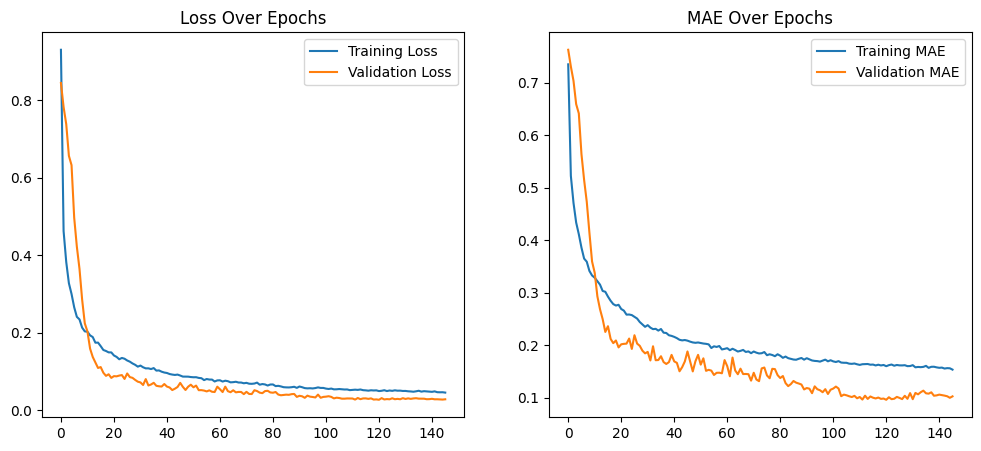

In [16]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('MAE Over Epochs')
plt.legend()
plt.show()

# Comparaison avec les vraies valeurs

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


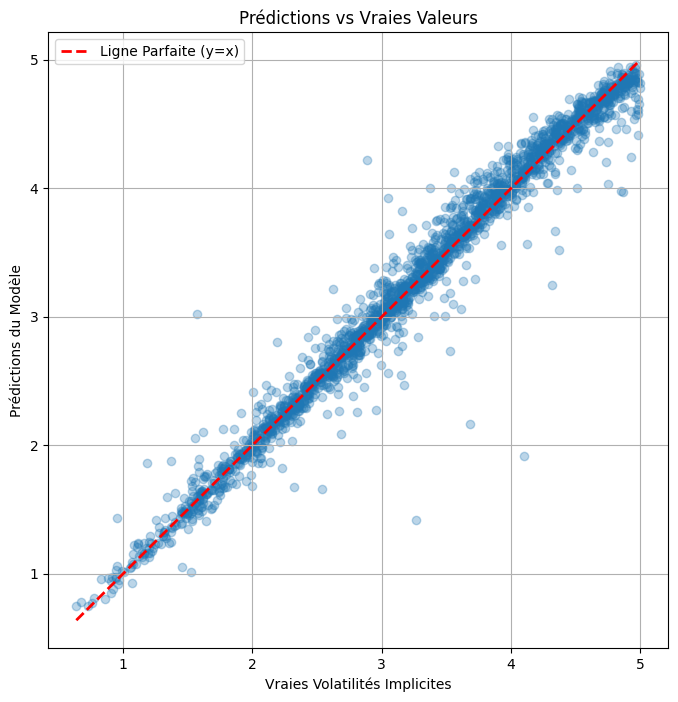

Erreur Absolue Moyenne (MAE) sur l'ensemble de validation: 0.09619
Coefficient de détermination (R²) sur l'ensemble de validation: 0.97256


In [17]:
# Faire des prédictions sur l'ensemble de validation
Y_pred_scaled = model.predict(X_val_scaled)

# Inverser la mise à l'échelle pour avoir des valeurs interprétables !
Y_pred = y_scaler.inverse_transform(Y_pred_scaled)

# Créer le graphique
plt.figure(figsize=(8, 8))
plt.scatter(Y_val, Y_pred, alpha=0.3)
plt.plot([Y_val.min(), Y_val.max()], [Y_val.min(), Y_val.max()], '--r', linewidth=2, label='Ligne Parfaite (y=x)')
plt.xlabel("Vraies Volatilités Implicites")
plt.ylabel("Prédictions du Modèle")
plt.title("Prédictions vs Vraies Valeurs")
plt.legend()
plt.grid(True)
plt.show()

# Calculer l'erreur finale
from sklearn.metrics import mean_absolute_error, r2_score
mae = mean_absolute_error(Y_val, Y_pred)
r2 = r2_score(Y_val, Y_pred)
print(f"Erreur Absolue Moyenne (MAE) sur l'ensemble de validation: {mae:.5f}")
print(f"Coefficient de détermination (R²) sur l'ensemble de validation: {r2:.5f}")